# Introduction to Bayesian modeling with PyMC3

This post is devoted to give an introduction to Bayesian modeling using [PyMC3](https://pymc-devs.github.io/pymc3/notebooks/getting_started.html), an open source probabilistic programming framework written in Python. Part of this material was presented in the Python Users Berlin (PUB) meet up.

<img src="images/PyMC3_banner.svg" alt="html" style="width: 400px;"/>

Why PyMC3? As described in the documentation:

- PyMC3’s user-facing features are written in pure Python, it leverages [Theano](http://deeplearning.net/software/theano/) to transparently transcode models to C and compile them to machine code, thereby boosting performance. 

- Theano is a library that allows expressions to be defined using generalized vector data structures called tensors, which are tightly integrated with the popular [NumPy](http://www.numpy.org/) ndarray data structure.

In addition, from a practical point of view, PyMC3 syntax is very transpartent from the mathematical point of view.

This post is not aimed to give a full treatment of the ~~mathematical details~~, as there are many good (complete and detailed) references around these topics. Also, we are not going to dive deep into PyMC3 as all the details can be found in the documentation. Instead, we are interested in giving an overview of the basic mathematical consepts combinded with examples (writen in Python code) which should make clear why [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) simulations are useful in Bayesian modeling. 

# 1. Mathematical Background

# 1.1 Bayes Theorem

## Frequentist vs Bayesian

*The essential difference between frequentist inference and Bayesian inference is the same as the difference between the two interpretations of what a "probability" means*.

**Frequentist inference** is a method of statistical inference in which conclusions from data is obtained by emphasizing the frequency or proportion of the data. 

**Bayesian inference** is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

## Conditional Probability

Let $A$ and $B$ be two events, then the *conditional probability* of $A$ given $B$ is defined as the ratio

$$
P(A|B):=\frac{P(A\cap B)}{P(B)}
$$

*Remark:* Formally we have a [probability space](https://en.wikipedia.org/wiki/Probability_space) $(\Omega, \mathcal{F}, P)$, where $\Omega$ is the sample space, $\mathcal{F}$ is a $\sigma$-algebra on $\Omega$ and $P$ is a probability measure. The events $A$, and $B$ are elements of $\mathcal{F}$ and we assume that $P(B)\neq 0$.

Observe in particular

$$
P(A|B)P(B)=P(A\cap B)=P(B\cap A) = P(B|A)P(A)
$$

## Bayes Theorem

From the last formula we obtain the relation

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)}
\end{equation}

which is known as [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).

**Example:** Suppose you are in the U-Bahn and you see a person with long hair. You want to know the probablity that this person is a woman. Consider the events \\(A=\\) woman \\(B=\\) long hair. You want to compute \\(P(A|B)\\). Suppose that you estimate \\(P(A)=0.5\\), \\(P(B)=0.4\\) and \\(P(B|A)=0.7\\) (the probability that a woman has long hair). Then, given these prior estimated probabilities, Bayes theorem gives  

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)} = \frac{0.7\times 0.5}{0.4} = 0.875.
\end{equation}

## Bayesian Approach to Data Analysis

Assume that you have a sample of observations $y_1,..., y_n$ of a random variable \\(Y\sim f(y|\theta)\\), where $\theta$ is a parameter for the distribution. Here we consider $\theta$ as a random variable as well. Following Bayes Theorem (its continuous version) we can write.

$$
f(\theta|y)=\frac{f(y|\theta)f(\theta)}{f(y)} = 
\displaystyle{\frac{f(y|\theta)f(\theta)}{\int f(y|\theta)f(\theta)d\theta}}
$$

- The function $f(y|\theta)$ is called the *likelihood*.

- $f(\theta)$ is the *prior* distribution of $\theta$.


Note that $f(y)$ *does not* depend on $\theta$ (just on the data), thus it can be considered as a "normalizing constant". In addition, it is often the case that the integral above is not easy to compute. Nevertheless, it is enough to consider the relation:

$$
f(\theta|y)  \propto \text{likelihood} \times \text{prior}.
$$

(Here $\propto$ denotes the proportionality relation)

## Example: Poisson Data

In order to give a better sense of the relation above we are going to study a concrete example. Consider $n$ samples of $Y\sim Poiss(\lambda)$. Recall that the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is given by:

$$
f(y_i|\lambda)=\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
$$

where $\lambda>0$. It is easy to verify that $E(Y)=\lambda$ and $Var(Y)=\lambda$. Parallel to the formal discussion, we are going to implement a numerical simulation:

In [1]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as ss
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 7]

In [2]:
# We set a seed so that the results are reproducible.
np.random.seed(5)

# number of samples.
n = 100

# true parameter.
lam_true = 2

# sample array.
y = np.random.poisson(lam=lam_true, size=n)

y

array([2, 4, 1, 0, 2, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 4, 2, 0, 0, 3, 6,
       1, 2, 1, 2, 5, 2, 3, 0, 1, 3, 1, 4, 1, 2, 4, 0, 6, 4, 1, 2, 2, 0,
       1, 2, 4, 4, 1, 3, 0, 3, 3, 2, 4, 2, 2, 1, 1, 2, 5, 2, 3, 0, 1, 1,
       1, 3, 4, 1, 3, 4, 2, 1, 2, 4, 2, 2, 1, 0, 2, 2, 3, 0, 3, 3, 4, 2,
       2, 1, 2, 1, 3, 0, 1, 0, 3, 3, 1, 2])

In [3]:
# mean of the sample.
y.mean()

2.06

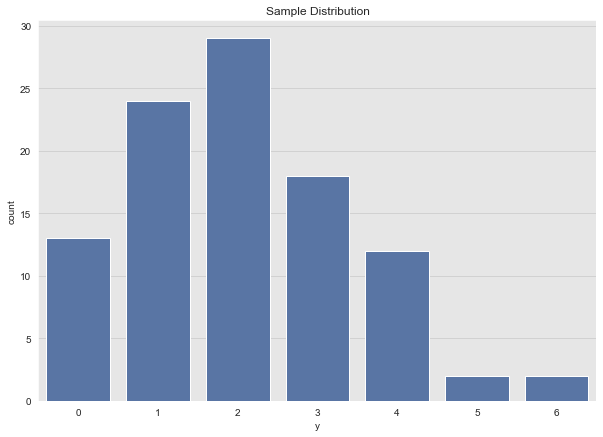

In [98]:
# Histogram of the sample.
fig, ax = plt.subplots()
sns.countplot(x=y, color=sns_c[0], ax=ax)
ax.set(title='Sample Distribution', xlabel='y');

### Prior: Gamma Distribution

Let us consider a [gamma](https://en.wikipedia.org/wiki/Gamma_distribution) prior distribution for the parameter $\lambda \sim \Gamma(a,b)$. Recall that the density function for the gamma distribution is

$$
f(\lambda)=\frac{b^a}{\Gamma(a)}\lambda^{a-1} e^{-b\lambda}
$$

where $a>0$ is the *shape* parameter and $b>0$ is the *rate parameter*.

The *expected value* and *variance* of the gamma distribution is 

$$
E(\lambda)=\frac{a}{b}
\quad
\text{and}
\quad
Var(\lambda)=\frac{a}{b^2}
$$

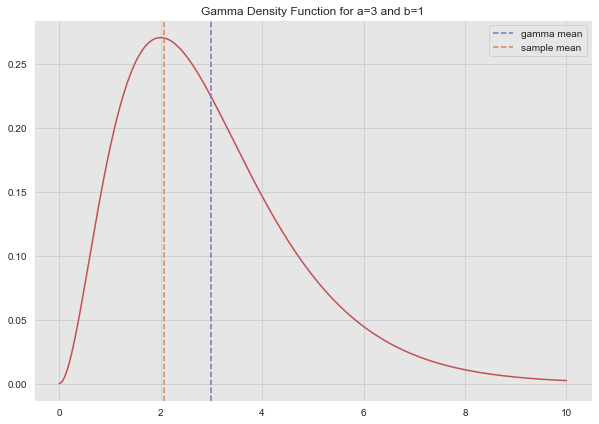

In [88]:
# Parameters of the prior gamma distribution.
a = 3 # shape
b = 1 # rate = 1/scale

x = np.linspace(start=0,stop=10, num=300)

fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3])
ax.axvline(x= a /b, color=sns_c[4], linestyle='--', label='gamma mean')
ax.axvline(x= y.mean(), color=sns_c[1], linestyle='--', label='sample mean')
ax.legend()
ax.set(title=f'Gamma Density Function for a={a} and b={b}')

# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

### Likelihood

As the observations are independent the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) function is

$$
f(y|\lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}
$$

In [89]:
# Define the likelihood function.
def likelihood(lam, y):
    
    factorials = np.apply_along_axis(
        lambda x: sp.gamma(x + 1),
        axis=0,
        arr=y
    )
    
    numerator = np.exp(- lam * y.size) * (lam ** (y.sum()))
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator / denominator  

### Posterior distribution for $\lambda$ up to a constant

As we are just interested in the structure of the posterior distribution, up to a constant, we see 

\begin{align}
f(\lambda|y)\propto & \text{likelihood} \times \text{prior}\\
\propto & \quad f(y|\lambda)f(\lambda)\\
\propto & \quad e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \lambda^{a-1} e^{-b\lambda}\\
\propto & \quad \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}\\
\end{align}

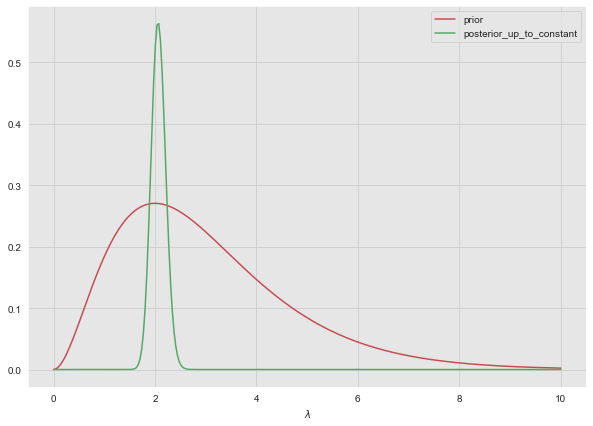

In [97]:
# Define the posterior distribution.
# (up to a constant)
def posterior_up_to_constant(lam, y):
    return likelihood(lam=lam, y=y) * prior(lam)

# Plot of the prior and (scaled) posterior distribution
# for the parameter lambda.
#
# We multiply the posterior distrubution function
# by the amplitude factor 2.5e74 to make it comparable
# with the prior gamma distribution.
fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3], label='prior')
ax.plot(x, 2.0e74 * posterior_up_to_constant(x,y), color=sns_c[2], label='posterior_up_to_constant')
ax.legend()
ax.set(xlabel='$\lambda$');

### True posterior distribution for $\lambda$

In fact, as  $f(\lambda|y) \propto\: \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}$, one verifies that the posterior distribution is again a gamma 

\begin{align}
f(\lambda|y) = \Gamma\left(\sum_{i=1}^n y_i+a, n+b\right)
\end{align}

This means that the gamma and Poisson distribution form a [conjugate pair](https://en.wikipedia.org/wiki/Conjugate_prior). 


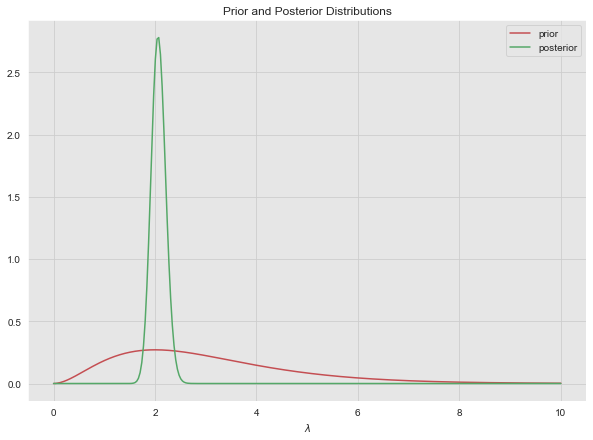

In [91]:
def posterior(lam, y):
    shape = a + y.sum()
    rate = b + y.size
    return ss.gamma.pdf(lam, shape, scale=1/rate)


fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3], label='prior')
ax.plot(x, posterior(x,y), color=sns_c[2], label='posterior')
ax.legend()
ax.set(title='Prior and Posterior Distributions', xlabel='$\lambda$');

We indeed see how the posterior distribution is concentrated around the true parameter \\(\lambda=2\\).

Note that the posterior mean is

\begin{align}
\frac{\sum_{i=1}^n y_i+a}{n+b} = \frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n}
\end{align}

That is, it is a weighted average of the prior mean $a/b$ and the sample average $\bar{y}$. As $n$ increases, 

\begin{align}
\lim_{n\rightarrow +\infty}\frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n} = \bar{y}.
\end{align}


In [92]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
shape / rate

2.0693069306930694

# 1.2 Markov Chain Monte Carlo  (MCMC) Approach

In the last example the posterior distribution was easy to identify. However, in paractice this is not usually the case and therefore, via Bayes Theorem, we would only know the posterior distribution up to a constant. This motivates the idea of using Monte Carlo simulation methods. How can we sample from a distribution that we do not know? The Metropolis–Hastings algorithm, explaned next, is one approach to tackle this problem.

## Metropolis–Hastings algorithm

Let $\phi$ be a function that is proportional to the desired probability distribution $f$. 

**Initialization:**

Pick $x_{0}$ to be the first sample, and choose an arbitrary probability density 

\begin{equation}
g(x_{n+1}| x_{n})
\end{equation}

that suggests a candidate for the next sample value $x_{n+1}$. Assume $g$ is symmetric.

**For each iteration:**

Generate a candidate $x$ for the next sample by picking from the distribution $g(x|x_n)$. Calculate the *acceptance ratio*

\begin{equation}
\alpha := \frac{f(x)}{f(x_n)} = \frac{\phi(x)}{\phi(x_n)}
\end{equation}

If $\alpha \geq 1$, automatically accept the candidate by setting

\begin{equation}
x_{n+1} = x.
\end{equation}

Otherwise, accept the candidate with probability $\alpha$. If the candidate is rejected, set

\begin{equation}
x_{n+1} = x_{n}.
\end{equation}

Why does this algorithm solve the initial problem? The full explanation is beyond the scope of this post (some references are provided at the end). It relies in the in the following result.

## Ergodic Theorem for Markov Chains 

**Theorem (Ergodic Theorem for Markov Chains)** If $\{x^{(1)} , x^{(2)} , . . .\}$ is an *irreducible*, *aperiodic* and *recurrent* [Markov chain](https://en.wikipedia.org/wiki/Markov_chain), then there is a unique probability distribution $\pi$ such that as $N\longrightarrow\infty$,

- $P(x^{(N)} ∈ A) \longrightarrow \pi(A)$.
- $\displaystyle{\frac{1}{N}\sum_{n=1}^{N} g(x^{(n)})) \longrightarrow    \int g(x)\pi(x) dx }$.

*Recall:*

- A Markov chain is said to be **irreducible** if it is possible to get to any state from any state. 

- A state $n$ has **period** $k$ if any return to state $n$ must occur in multiples of $k$ time steps.

- If $k=1$, then the state is said to be **aperiodic**. 

- A state $n$ is said to be **transient** if, given that we start in state $n$, there is a non-zero probability that we will never return to $i$. 

- A state $n$ is **recurrent**  if it is not transient.


# 2. PyMC3 Syntax

Now we perform a MCMC simulation for the data described above. Note how easy is to write the model from the mathematical description.

In [59]:
model = pm.Model()

with model as toy_model:
    
    # Define the prior of the parameter lambda.
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=lam, observed=y)
    
    # Consider 2000 draws and 3 chains.
    trace = pm.sample(draws=2000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


If we do a trace plot we can see two results:

- We see the simulated posterior distribution for 4 independent Markov Chains (so that, when combined, avoid the dependence on the initial point). The 3 different chains correspond to the color blue, green and orange.

- The sample value of lambda for each iteration.

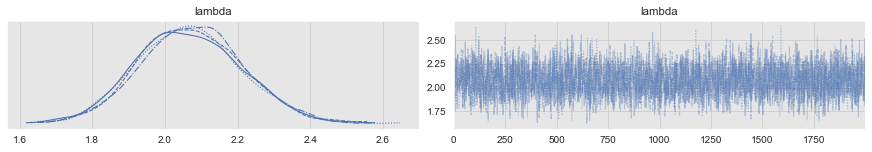

In [62]:
az.plot_trace(trace);

In [95]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,2.071,0.144,1.804,2.34,0.002,0.002,3488.0,5549.0,1.0


We can also see the mean and quantile information for the posterior distribution.

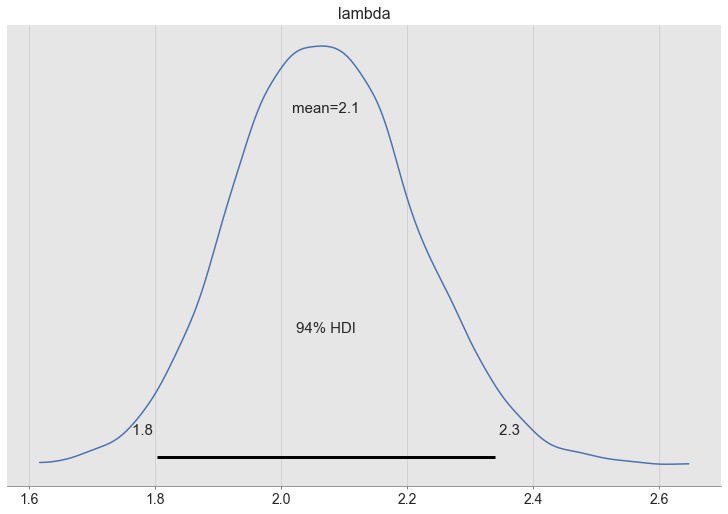

In [64]:
az.plot_posterior(trace);

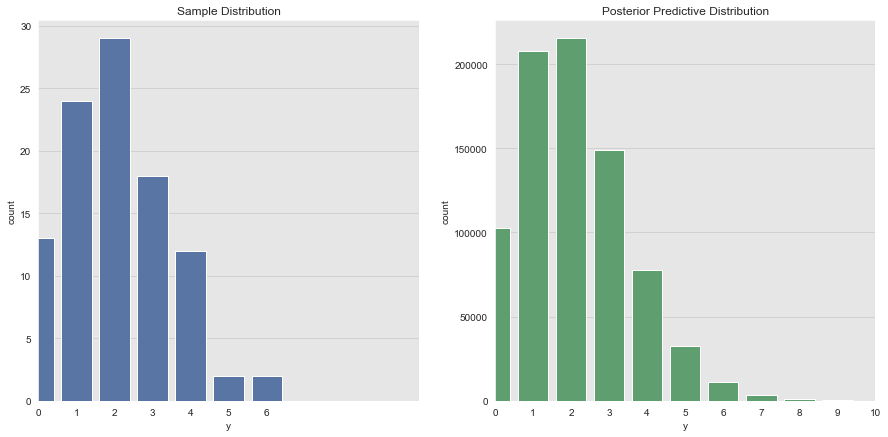

In [94]:
with toy_model:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace)
    )

posterior_sampels = forecast_1.posterior_predictive['y_obs'].values.flatten()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=y, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution', xlabel='y', xlim=(0, 10))
sns.countplot(x=posterior_sampels, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(0, 10));

# 3. Bayesian Hierarchical Modeling: A Chocolate Cookies Example.

<img src="images/monster.jpg" alt="html" style="width: 400px;"/>

Now we are going to treat a more complicated example which illustrated a hierarchical mdel.
This case of study is taken from the (strongly recomended!) online course:

**Bayesian Statistics: Techniques and Models:**

https://www.coursera.org/learn/mcmc-bayesian-statistics

There, the MCMC simulations are done with [JAGS](http://mcmc-jags.sourceforge.net/) in [R](https://www.r-project.org/). As a matter of fact, this course motivated me to explore an analogous tool for Python.

## 3.1 The data

Assume there is a big factory producing chocolate cookies around the world. The cookies follow a unique recipe, but you want to study the chocolate chips distribution for cookies produced in 5 different locations.

- On the one hand side you would assume that the distribution across the locations is similar, as they all come from a unique recipe. This is why you may not want to model each location separately. 

- On the other hand, in reality, as the locations are not exacly the same you might expect some differences between each location.  This is why you may not want to model all locations at once.

To overcome these restrictions, a hierarchical can be a feasible approach.  

In [65]:
import pandas as pd

# We begin reading the data into a pandas dataframe.
cookies = pd.read_csv('data/cookies.dat', sep = ' ')

cookies.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/cookies.dat'

In [13]:
# Let us verify the number of locations.
cookies.location.unique()

array([1, 2, 3, 4, 5])

Let us start with some visualization of the data.

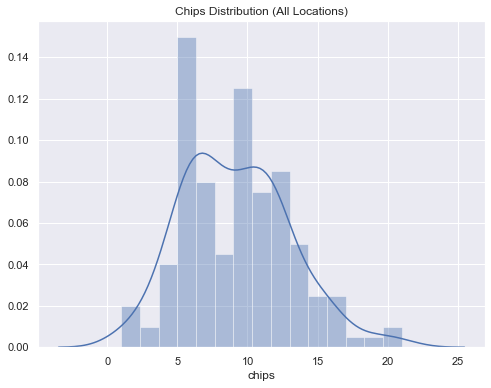

In [14]:
# Histogram distribution of chocolate chips
# for all cookies.
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(cookies['chips'], bins=15, ax=ax);
ax.set(title='Chips Distribution (All Locations)');

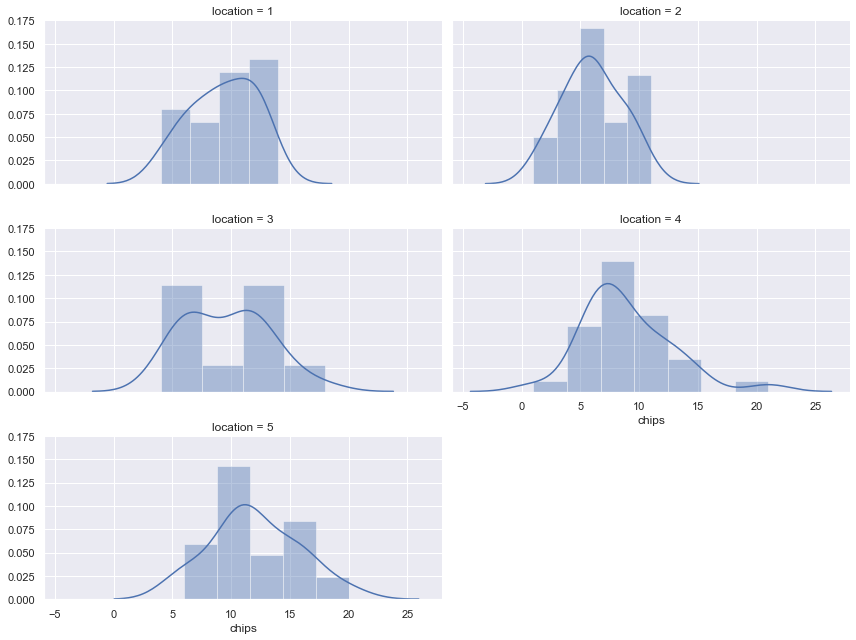

In [15]:
# Histogram distribution of chocolate chips
# for cookies in each location.
g = sns.FacetGrid(data=cookies, col='location', col_wrap=2, height=3, aspect=2)
g = g.map(sns.distplot, 'chips')

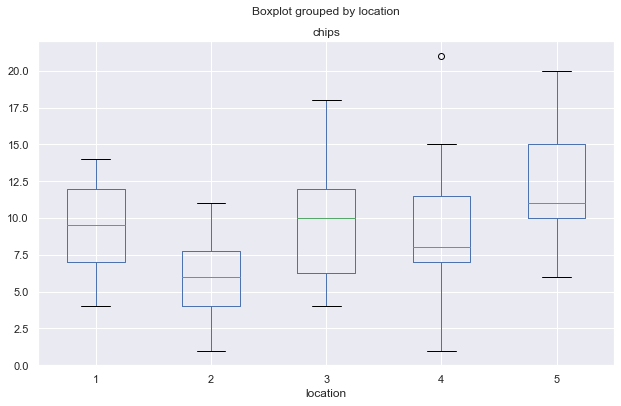

In [16]:
# Box plot for different locations.
fig, ax = plt.subplots(figsize=(10,6))
cookies.boxplot(column='chips', by='location', ax=ax);

##  3.2 The model: Hierarchical Approach


- Hierarchical Model:

We model the chocolate chip counts by a Poisson distribution with parameter \\(\lambda\\). Motivated by the example above, we choose a gamma prior.

\begin{align}
chips \sim  Poiss(\lambda)
\quad\quad\quad
\lambda \sim  \Gamma(a,b)
\end{align}

- Parametrization:

We parametrize the shape and scale of the gamma prior with the mean \\(\mu\\) and variance \\(\sigma^2\\).

\begin{align}
a=\frac{\mu^2}{\sigma^2}
\quad\quad\quad
b=\frac{\mu}{\sigma^2}
\end{align}

- Prior Distributions:

We further impose prior for these parameters

\begin{align}
\mu  \sim  \Gamma(2,1/5)
\quad\quad\quad
\sigma  \sim  Exp(1)
\end{align}





(1, 10)

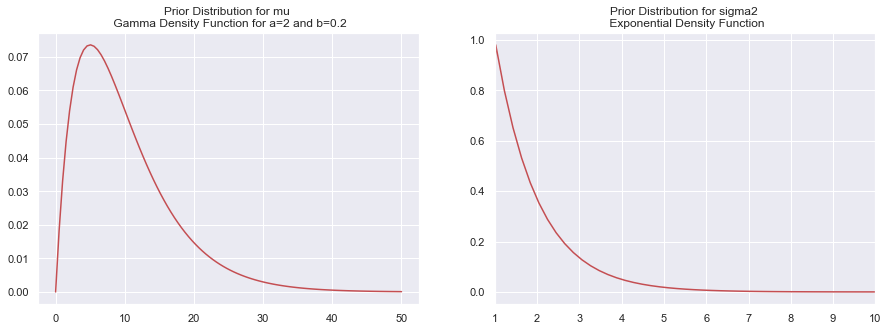

In [17]:
x = np.linspace(start=0, stop=50, num=100)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x, ss.gamma.pdf(x,a=2,scale=5), 'r-')
plt.title('Prior Distribution for mu \n Gamma Density Function for a={} and b={}'.format(2,1/5))

plt.subplot(1, 2, 2)
x = np.linspace(0,10)
plt.plot(x, ss.expon.pdf(x,1), 'r-')
plt.title('Prior Distribution for sigma2 \n Exponential Density Function')
plt.xlim(1,10)

Let us write the model in PyMC3. Note how the syntax mimics the mathematical formulation.

In [18]:
model = pm.Model()

with model:
    
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    
    # Parametrization for the shape parameter.
    alpha =  mu**2/sigma**2
    
    # Parametrization for the scale parameter.
    beta = mu/sigma**2
    
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        shape=cookies.location.values.max()
    )
    
    # Likelihood function for the data.
    chips = [
        pm.Poisson('chips_{}'.format(i),lam[i], 
        observed=cookies[cookies.location==i+1].chips.values) 
        for i in range(cookies.location.values.max())
    ] 
    
    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 1000, 3
    
    n_sim = n_draws*n_chains
    
    trace = pm.sample(draws=n_draws, chains=n_chains)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lam, sigma, mu]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:02<00:00, 1815.91draws/s]


## 3.3 Diagnostics

Many [diagnostic](https://pymc-devs.github.io/pymc3/api/diagnostics.html) options are described in the PyMC3 documentation. 

/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

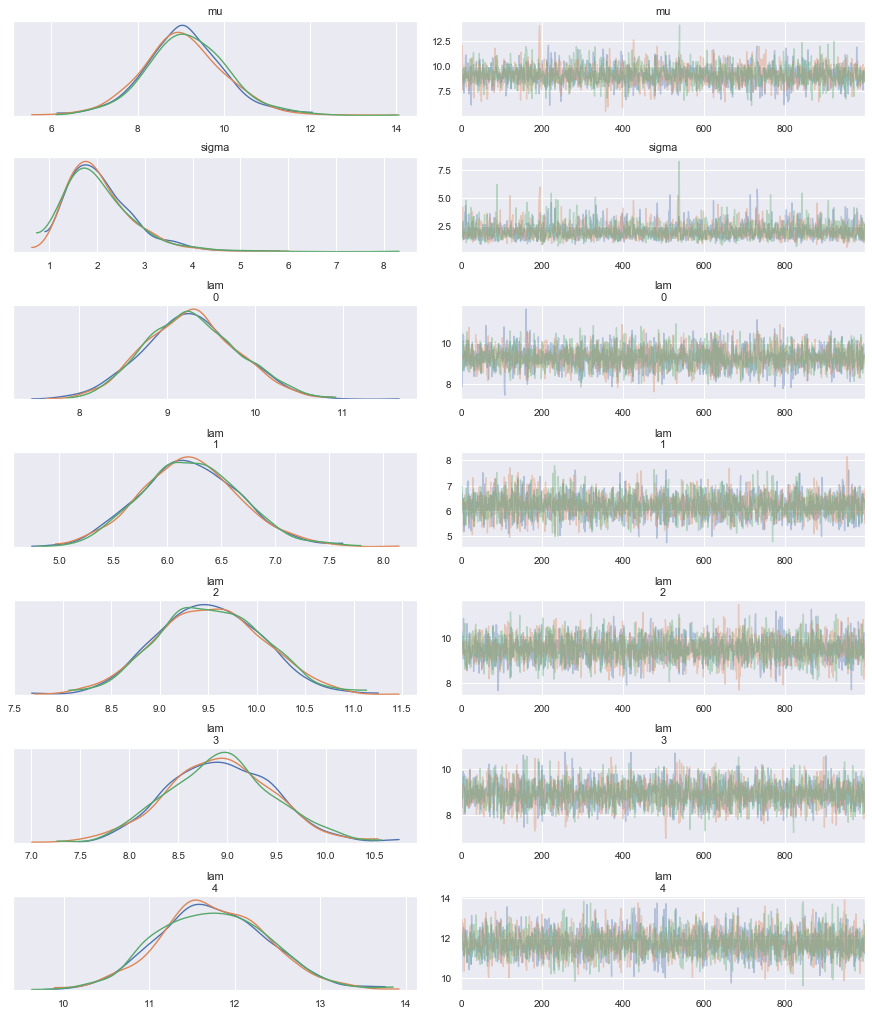

In [19]:
pm.traceplot(trace);

From the traceplot we see that the chains have converged. We can also have a detailed summary of the posterior distribution for each parameter:

In [20]:
pm.summary(trace)

/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,9.104871,0.952266,0.019789,7.285942,11.142347,2522.978566,1.001637
sigma,2.075416,0.716848,0.013315,0.988354,3.541359,2510.182129,0.999958
lam__0,9.277816,0.529706,0.008511,8.353204,10.406595,4050.792217,0.999807
lam__1,6.221088,0.461659,0.007158,5.306228,7.100886,3812.117511,0.999808
lam__2,9.520956,0.544345,0.008374,8.516351,10.607144,3723.180815,0.999935
lam__3,8.932577,0.531530,0.009103,7.861659,9.922982,3353.991802,0.999881
lam__4,11.753710,0.639027,0.010974,10.547972,13.023027,3529.810115,0.999560


We can also see this visually.

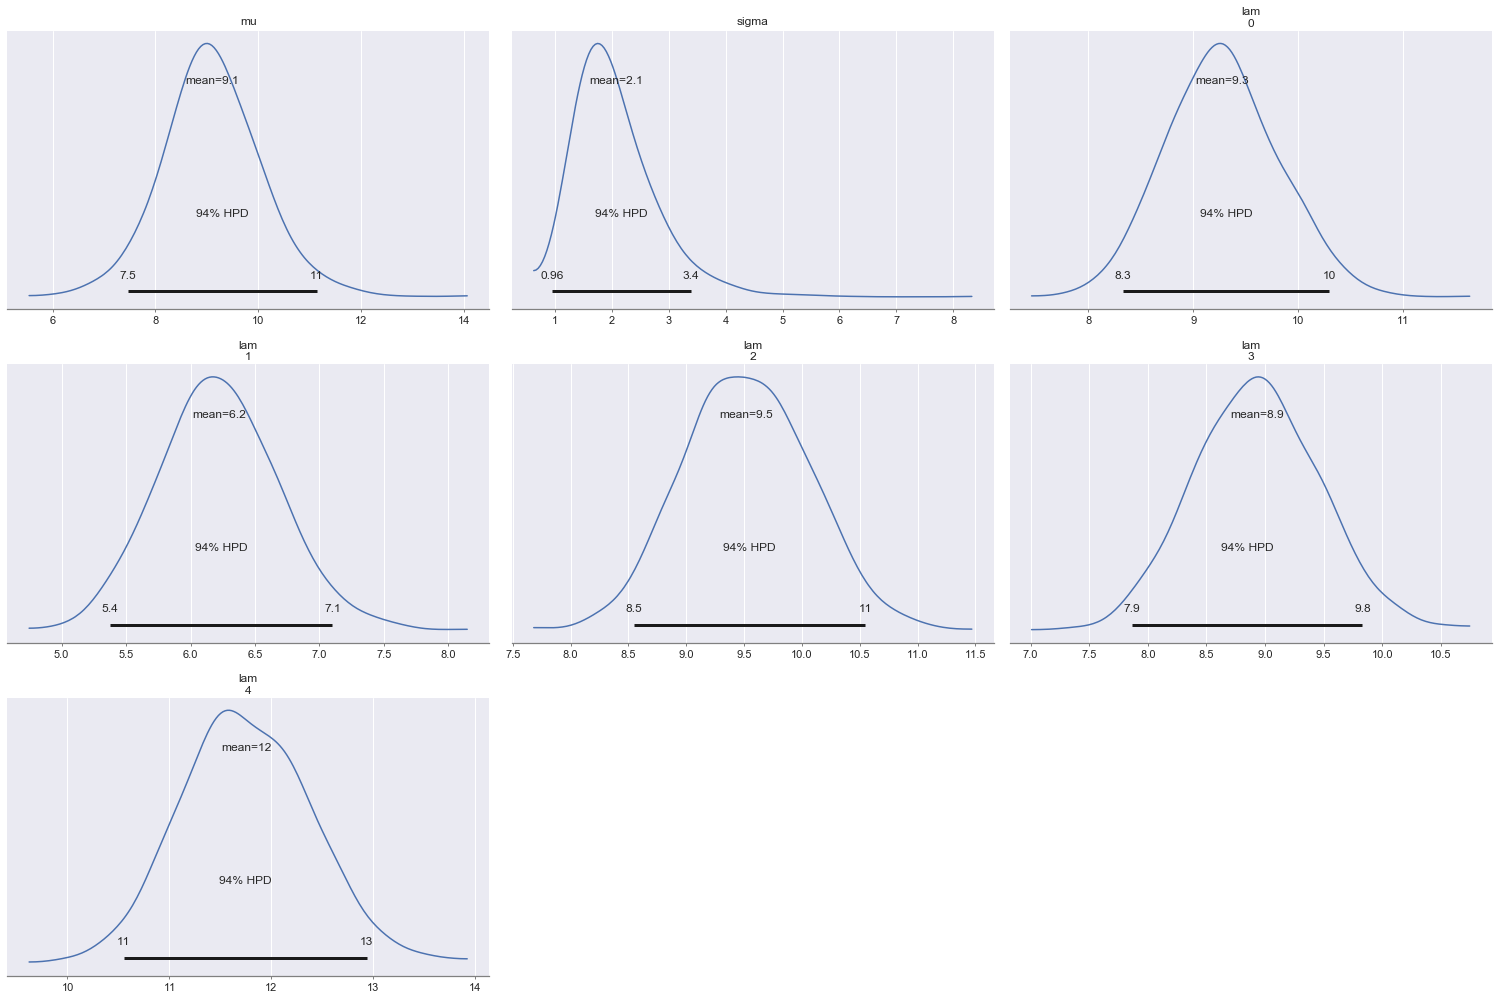

In [21]:
pm.plot_posterior(trace);

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence. 

In [22]:
pm.gelman_rubin(trace)

{'mu': 1.0016372262426347,
 'sigma': 0.9999579325854048,
 'lam': array([0.9998075 , 0.99980835, 0.99993469, 0.99988124, 0.99956018])}

We can also test for correlation between samples in the chains. We are aiming for zero auto-correlation to get "random" samples from the posterior distribution.

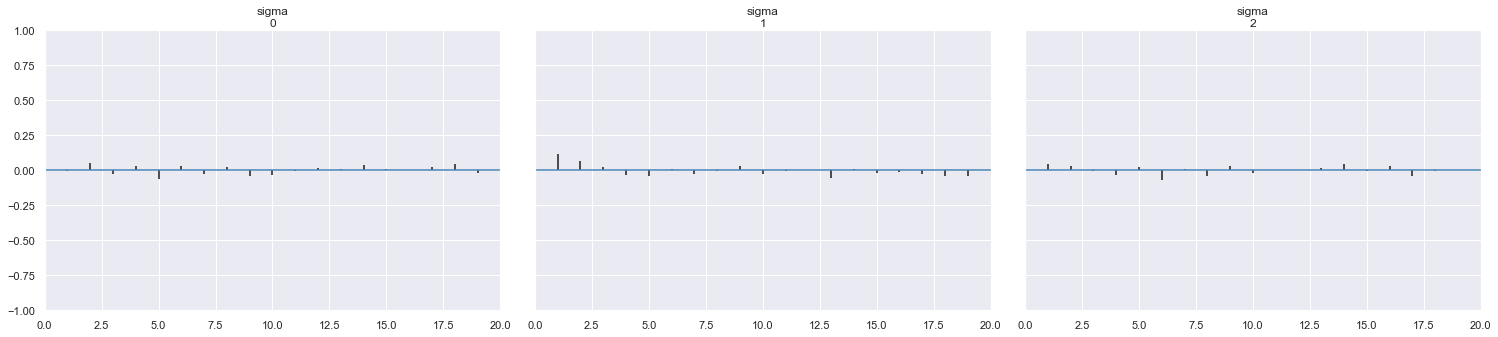

In [23]:
# Auto-correlation of the parameter sigma for the 3 chains.
pm.autocorrplot(trace, var_names=['sigma'], max_lag=20);

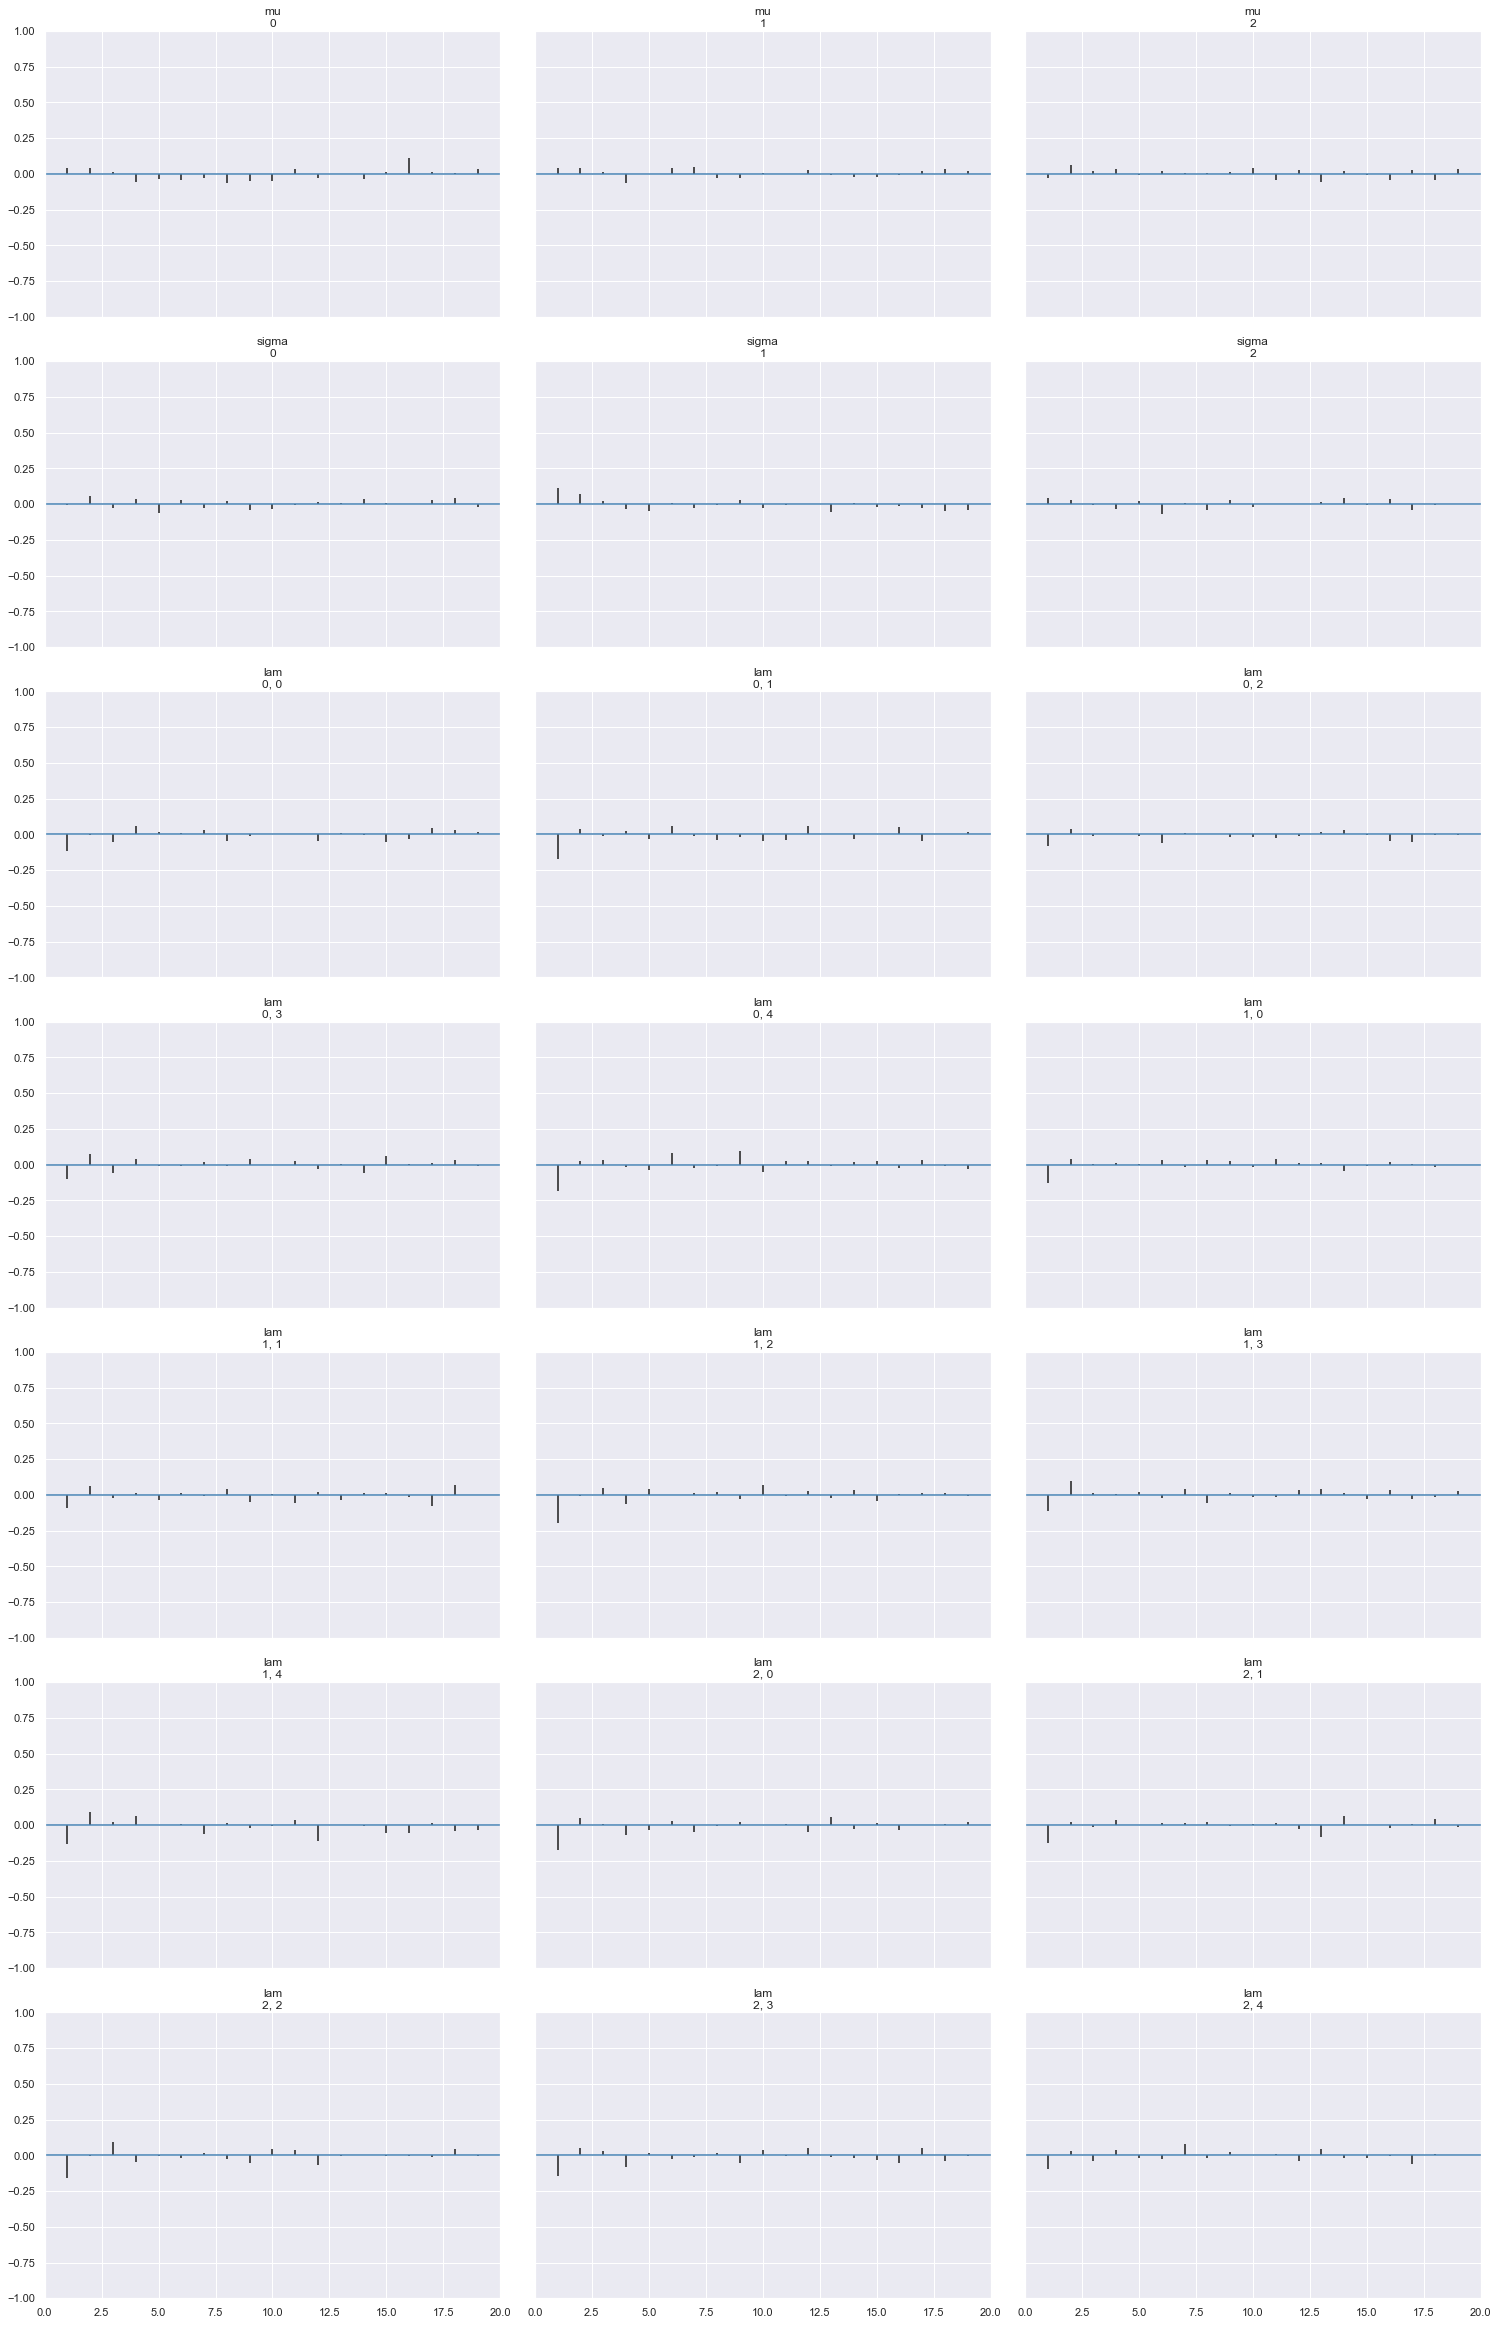

In [24]:
# We can also consider all the variables simultaneously. 
pm.autocorrplot(trace, max_lag=20);

From these plots we see that the auto-correlation is not problematic. Indeed, we can test this through the *effective sample size*, which sould be close to the total sumber of samples `n_sim`.

In [25]:
pm.diagnostics.effective_n(trace)

{'mu': 2522.9785658157243,
 'sigma': 2510.182129406361,
 'lam': array([4050.79221675, 3812.11751115, 3723.18081493, 3353.99180192,
        3529.81011549])}

Finally, we can compute the [Watanabe–Akaike information criterion](https://en.wikipedia.org/wiki/Watanabe–Akaike_information_criterion).

In [26]:
pm.waic(trace, model)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=789.764634126058, WAIC_se=21.395864846123082, p_WAIC=5.844326163346711, var_warn=1)

## 3.4 Residual analysis

In order to evaluate the model results we analyze the behaviour of the residuals.

In [27]:
# Compute the mean of the simulation.
lambda_mean = np.apply_along_axis(np.mean, 0, trace['lam'])

# Compute for each sample the posterior mean.
cookies['yhat'] = cookies.location.apply(lambda x: lambda_mean[x-1])

# Compute the residuals.
cookies['resid'] = cookies.apply(lambda x: x.chips - x.yhat, axis=1)

cookies.head()

,chips,location,yhat,resid
0,12,1,9.277816,2.722184
1,12,1,9.277816,2.722184
2,6,1,9.277816,-3.277816
3,13,1,9.277816,3.722184
4,12,1,9.277816,2.722184


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


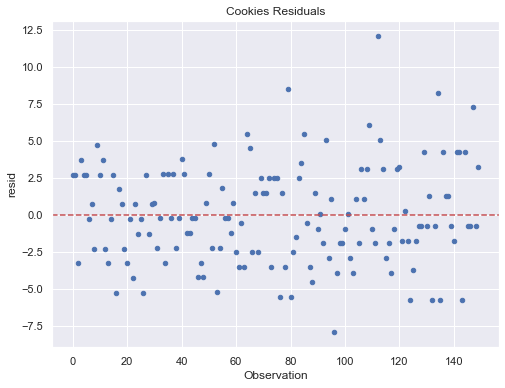

In [28]:
# Cookies Residuals
fig, ax = plt.subplots(figsize=(8, 6))
cookies.reset_index().plot.scatter(x='index', y='resid', ax=ax)
ax.axhline(y=0.0, color='r', linestyle='--')
ax.set(title='Cookies Residuals', xlabel='Observation');

We do not see a particular partern in the scatter plot of the residuals against the observation.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


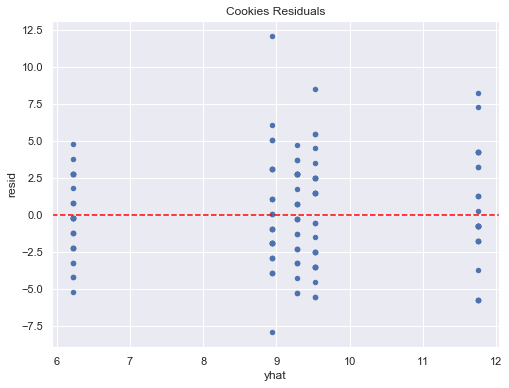

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
cookies.plot.scatter(x='yhat', y='resid', ax=ax)
ax.axhline(y=0.0, color='red', linestyle='--')
ax.set(title='Cookies Residuals');

## 3.5 Predictions

Finally, we are going to illustrate how to use the simulation results to derive predictions.

### 3.5.1 For a known location

Let us consider Location 1. We want, for example, to compute the posterior probability the next cookie in this location has less than 7 chips.

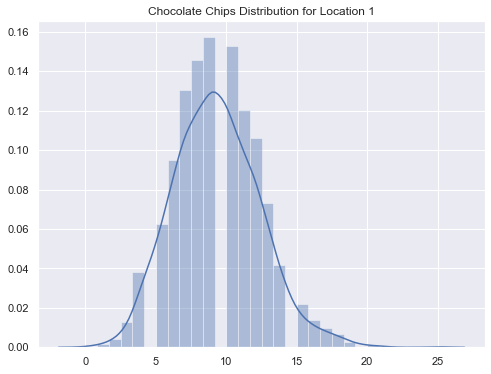

In [30]:
# We generate n_sim samples of a Poisson distribution for 
# each value for lam_0 (location 1) simulation..
y_pred_location_1 = np.random.poisson(lam=trace['lam'][:,0] , size=n_sim)

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_pred_location_1, bins=30, ax=ax)
ax.set(title='Chocolate Chips Distribution for Location 1');

In [31]:
# Probability the next cookie in location has less than 7 chips.
(y_pred_location_1 < 7).astype(int).mean()

0.17866666666666667

### 3.5.1 For a new location

Now assume we want to open a new location. First, we want to compute the posterior probability that this new location has \\(\lambda > 15\\).

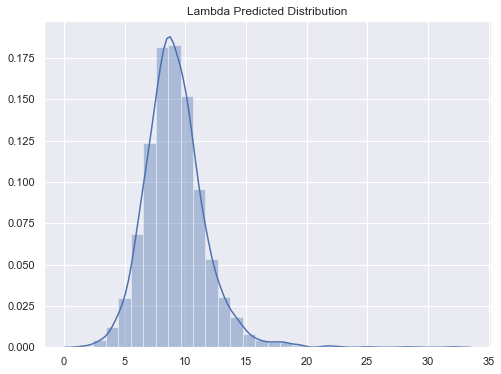

In [32]:
# Posterior distribution of for a an b 
# from the simulated values of mu and sigma2.
post_a = trace['mu']**2/trace['sigma']**2
post_b = trace['mu']/trace['sigma']**2

# We now generate samples of a gamma distribution 
# with these generated parameters of a and b.
lambda_pred_dist = np.random.gamma(post_a, 1/post_b, n_sim) 

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(lambda_pred_dist, bins=30, ax=ax)
ax.set(title='Lambda Predicted Distribution');

In [33]:
# Posterior probability a new location has lambda > 15.
(lambda_pred_dist > 15).astype(int).mean()

0.019333333333333334

Now we answer a question at the next level of the hierarchical model. We want to calculate the posterior probability for a cookie produced in a new location to have more than 15 chocolate chips.

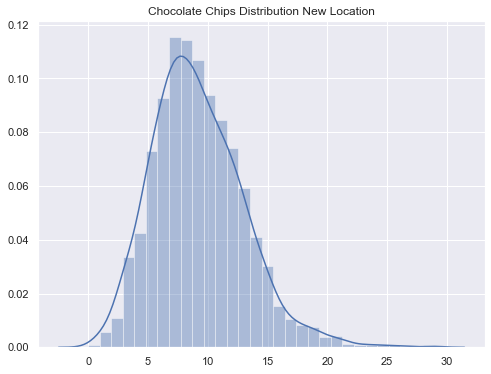

In [34]:
# Posterior distribution of the chips.
# Here we use the values of lambda obtained above.
cookies_pred_dist = np.random.poisson(lam=lambda_pred_dist, size=n_sim)

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(cookies_pred_dist, bins=30, ax=ax)
ax.set(title='Chocolate Chips Distribution New Location');

In [35]:
# Posterior probability that a cookie produced 
# in a new location has more than 15 chocolate chips.
(cookies_pred_dist>15).astype(int).mean()

0.054

# 4 References and Further Reading

Here we provide some suggested references used in this post and also to go deeper in the subject.

## 4.1 Bayesian Probability


- [Coursera: Bayesian Statistics: From Concept to Data Analysis](https://www.coursera.org/learn/bayesian-statistics)

- [Coursera: Bayesian Statistics: Techniques and Models](https://www.coursera.org/learn/mcmc-bayesian-statistics)

- [A First Course in Bayesian Statistical Methods, Peter D. Hoff](http://www.springer.com/us/book/9780387922997)

- [An Introduction to Bayesian Analysis: Theory and Methods, Ghosh, Jayanta K., Delampady, Mohan, Samanta, Tapas](http://www.springer.com/la/book/9780387400846)

## 4.2 PyMC3

- [Documentation](https://pymc-devs.github.io/pymc3/index.html)

- [Probabilistic Programming in Python using PyMC, John Salvatier, Thomas Wiecki, Christopher Fonnesbeck](https://arxiv.org/abs/1507.08050)